In [29]:
import numpy as np
import matplotlib
from matplotlib import ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cryoelectronics.cryoel_model import discretize_pulses, \
    optimizer, n_digits_discrete_opt, create_discrete_optimizer

from qopt import *
import os

latex_font = {'family': 'Times New Roman',
              'size': 10}
matplotlib.rc('font', **latex_font)
plt.rcParams["mathtext.fontset"] = "cm"


root_folder = r"C:\Users\julia\Desktop\SimulationData\Cryoelectronics"

continuous_folder = os.path.join(root_folder, "ContinuousOptimization")
discrete_folder = os.path.join(root_folder, "DiscreteOptimization")

assert os.path.isdir(continuous_folder)
assert os.path.isdir(discrete_folder)

identifier = "2022_09_23_first_execution"


c_dir = os.path.join(continuous_folder, identifier)
d_dir = os.path.join(discrete_folder, identifier)

In [ ]:
# discretize optimal pulses
c_file = os.path.join(c_dir, "ContinuouslyOptimizedPulses")
data_continuous = DataContainer.from_pickle(c_file)

n_opt = len(data_continuous.final_parameters)
optimized_pulses = np.stack(data_continuous.final_parameters, axis=2)

continuously_optimized_costs_syst = np.zeros(shape=(len(n_digits_discrete_opt), n_opt), dtype=float)
continuously_optimized_costs_noise = np.zeros(shape=(len(n_digits_discrete_opt), n_opt), dtype=float)


In [ ]:
# calculate data
for j, n_digits in enumerate(n_digits_discrete_opt):
    integer_pulses, discretized_optimal_pulses = discretize_pulses(n_digits=n_digits, pulses=optimized_pulses)
    for i in range(n_opt):
        x = optimizer.system_simulator.wrapped_cost_functions(discretized_optimal_pulses[:, :, i])
        continuously_optimized_costs_syst[j, i] = x[0]
        continuously_optimized_costs_noise[j, i] = x[1]


In [42]:
annealed_costs_syst = np.zeros(shape=(len(n_digits_discrete_opt), n_opt), dtype=float)
annealed_costs_noise = np.zeros(shape=(len(n_digits_discrete_opt), n_opt), dtype=float)
deviation_stored_values = np.zeros(shape=(len(n_digits_discrete_opt), n_opt), dtype=float)

annealed_final_costs_from_pickle = np.zeros(shape=(len(n_digits_discrete_opt), n_opt), dtype=float)


In [43]:
# recalculate discrete data (I didn't save them separately in the first simulation)

for j, n_digits in enumerate(n_digits_discrete_opt):
    discrete_optimizer = create_discrete_optimizer(n_digits=n_digits)
    d_file = os.path.join(d_dir, 'AnnealedPulsesNDigits' + str(n_digits))
    data_discrete = DataContainer.from_pickle(d_file)
    annealed_final_costs_from_pickle[j, :] = data_discrete.final_costs
    for k, pulse in enumerate(data_discrete.final_parameters):
        infid = discrete_optimizer.system_simulator.wrapped_cost_functions(pulse=pulse)
        annealed_costs_syst[j, k] = infid[0]
        annealed_costs_noise[j, k] = infid[1]
        deviation_stored_values[j, k] = np.abs(data_discrete.final_costs[k] - np.linalg.norm(infid))




In [4]:
# store recalculated data
array_names = ['continuously_optimized_costs_syst',
               'continuously_optimized_costs_noise',
               'annealed_costs_syst',
               'annealed_costs_noise']
file_names = [
    os.path.join(c_dir, s)
    for s in array_names
]
for file_name, data in zip(file_names, [continuously_optimized_costs_syst, continuously_optimized_costs_noise, annealed_costs_syst, annealed_costs_noise]):
    np.save(file_name, data)

In [ ]:
# load data
for file_name, data in zip(file_names, [continuously_optimized_costs_syst, continuously_optimized_costs_noise]):
    data = np.load(file_name)


In [5]:
# positions we need to have 4 places for each digit number

positions = np.zeros(shape=(4, len(n_digits_discrete_opt)), dtype=float)
for i in range(4):
    positions[i, :] = (4 * np.arange(len(n_digits_discrete_opt)) + i - 1.5) / 4 + n_digits_discrete_opt[0]


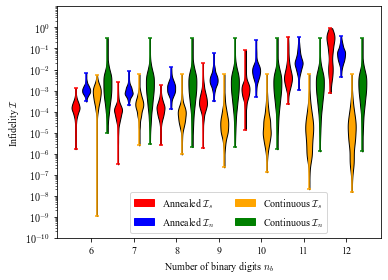

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(395.45 / 72, 4))

labels = [r'Annealed $\mathcal{I}_{s}$',
          r'Annealed $\mathcal{I}_{n}$',
          r'Continuous $\mathcal{I}_{s}$',
          r'Continuous $\mathcal{I}_{n}$']
colors = ['red', 'blue', 'orange', 'green']
patches = []

for i, dataset in enumerate([
    annealed_costs_syst,
    annealed_costs_noise,
    continuously_optimized_costs_syst,
    continuously_optimized_costs_noise]):

    if dataset is None:
        continue

    dataset[dataset == 0] = 1e-9
    log_data_set = np.log10(dataset + 1e-10)

    parts = ax.violinplot(
        dataset=[log_data_set[k] for k in range(len(log_data_set))],
        positions=positions[i, :],
        showextrema=[False, ] * len(dataset),
        widths=[.75 / 4, ] * len(dataset),
    )
    # artificial log scale
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    ymin, ymax = ax.get_ylim()
    tick_range = np.arange(np.floor(ymin), ymax)
    ax.yaxis.set_ticks(tick_range)
    ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)

    for key in ['cmins', 'cmaxes', 'cbars']:
        parts[key].set_color(colors[i])

    for pc in parts['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    patches.append(mpatches.Patch(color=colors[i], label=labels[i]))


ax.legend(handles=patches,
          bbox_to_anchor=(.85,0),
          ncol=2,
          loc="lower right")

ax.set_xlabel('Number of binary digits $n_b$')
ax.set_ylabel('Infidelity $\mathcal{I}$')

fig.tight_layout()
fig.savefig(os.path.join(
    r"C:\Users\julia\Desktop\SimulationData\Cryoelectronics\Figures",
    "AnnealedRounded.eps"
))

# This does not look right. probably I will have to convert the data to a logscale manually.
# I should verify this with a log histogram